In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output


In [2]:
BATCH_SIZE = 128
LATENT = 2
CLASSES = 10

In [3]:
a = torch.randn(1, 10, 10, 10)
print(a.size())
b = nn.ConvTranspose2d(10, 5, (2, 2), 2)
a = b(a)
print(a.size())


torch.Size([1, 10, 10, 10])
torch.Size([1, 5, 20, 20])


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.l1  = nn.Linear(in_features=LATENT+CLASSES, out_features=2**8)
        self.l2  = nn.Linear(in_features=2**8, out_features=2**9)
        self.l3  = nn.Linear(in_features=2**9, out_features=28*28)
 
        self.drop = nn.Dropout(p=0.2)

    def forward(self, z, label):
        x = torch.cat((z, label), axis=1)

        x = F.leaky_relu(self.l1(x))
        x = self.drop(x)
        x = F.leaky_relu(self.l2(x))
        x = self.drop(x)
        x = self.l3(x)

        x = torch.sigmoid(x)
        return x.view(-1, 1, 28, 28)

gen = Generator().cuda()

In [5]:
#         labels_sq = labels.view(-1, CLASSES, 1).repeat(1, 1, sq).view(-1, CLASSES, d2, d3)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.l1 = nn.Linear(in_features=28*28+10,   out_features=2**8)
        self.l2 = nn.Linear(in_features=2**8, out_features=2**6)
        self.l3 = nn.Linear(in_features=2**6,    out_features=1)
        
        self.drop = nn.Dropout(p=0.05)
        
    def forward(self, x, labels):
        x = x.view(-1, 28*28)
        x = torch.cat((x, labels), 1)
        
        x = F.leaky_relu(self.l1(x))
        x = self.drop(x)
        x = F.leaky_relu(self.l2(x))
        x = self.drop(x)
        x = self.l3(x)
        
        return torch.sigmoid(x)
    
dis = Discriminator().cuda()

In [6]:
# a = torch.Tensor([0, 1, 0, 1, 0, 0]).view(-1, 3, 1)
# a.repeat(1, 1, 4).view(-1, 3, 2, 2)

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


def imshow(img, ax, name=None):
    img = np.transpose(img.numpy(), (1, 2, 0))
    ax.imshow(img)
    ax.axis('off')
    if name != None:
        plt.savefig(name + ".png")
    else:
        plt.show()

In [8]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE*4, shuffle=False)

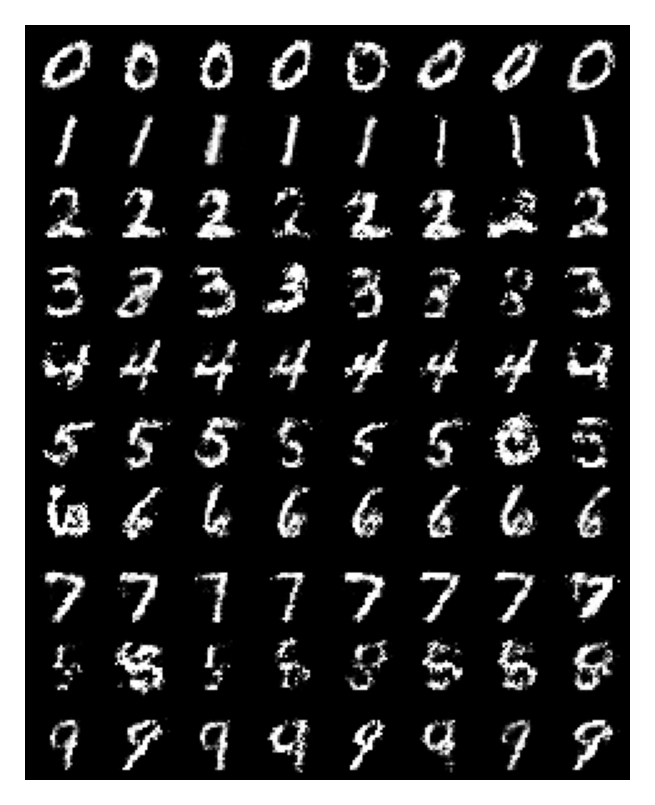

torch.Size([80, 1, 28, 28])


In [74]:
n = torch.Tensor([i for i in range(10) for j in range(8)]).view(-1, 1).long()
labels = torch.zeros(80, 10).scatter_(1, n, 1.0).cuda()
data = gen(torch.randn(80, LATENT).cuda(), labels).cpu()
fig, ax = plt.subplots()
fig.dpi = 250
imshow(torchvision.utils.make_grid(data.detach()), ax)
print(data.shape)
plt.close()

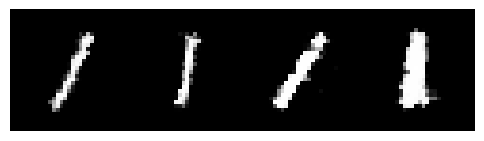

torch.Size([4, 1, 28, 28])


In [51]:
n = torch.Tensor([1]*4).view(-1, 1).long()
labels = torch.zeros(4, 10).scatter_(1, n, 1.0).cuda()
data = gen(torch.randn(4, LATENT).cuda(), labels).cpu()
fig, ax = plt.subplots()
fig.dpi = 100
imshow(torchvision.utils.make_grid(data.detach()), ax)
print(data.shape)
plt.close()

In [26]:
losses_g = []
losses_d = []
dis_errors = []
gen_errors = []
dis_err_plt = []
gen_err_plt = []
gen = Generator().cuda()
dis = Discriminator().cuda()

n = torch.Tensor([i for i in range(10) for j in range(8)]).view(-1, 1).long()
fixed_labels = torch.zeros(80, 10).scatter_(1, n, 1.0).cuda()
fixed_noise  = torch.randn(80, LATENT).cuda()

real_label = 0.9
fake_label = 0.0

In [31]:
import torch.optim as optim

op_gen = optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.999))
op_dis = optim.Adam(dis.parameters(), lr=0.0001, betas=(0.5, 0.999)) 
criterion = nn.BCELoss()


In [28]:
def dis_err(dis_out_l):
    return torch.mean(-torch.log(dis_out_l + 1e-10))

def gen_err(dis_out_g):
    return torch.mean(-torch.log(1.0-dis_out_g + 1e-10))

def dis_loss(derr, gerr):
    return (derr + gerr)*0.5

def gen_loss(gerr):
    return gerr

In [29]:
a = torch.full((1, 5,), 0.9)
b = torch.full((1, 2,), 1.1)
c = torch.cat((a, b), 1)
c.size()[0]

1

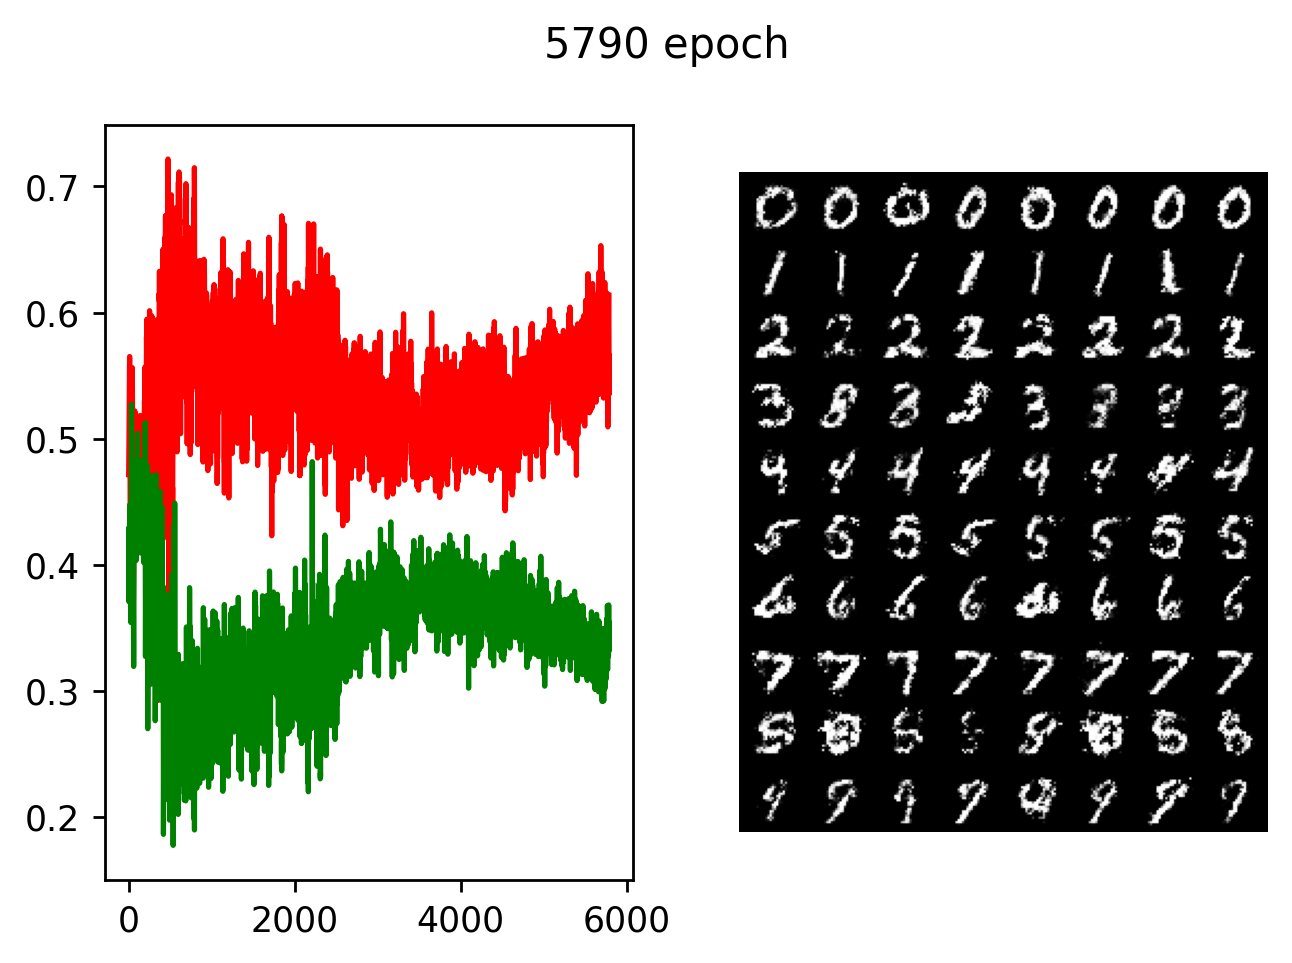

KeyboardInterrupt: 

In [32]:
dataiter = iter(trainloader)
stepsD = 1
stepsG = 3

for epoch in range(10000):
    try:
        # Discriminator
        for i in range(stepsD):
            op_gen.zero_grad()
            op_dis.zero_grad()
            # True
            imgs, nums = next(dataiter)
            
            labels = torch.zeros(imgs.size()[0], 10).scatter_(1, nums.view(-1, 1), 1.0).cuda()
            o = dis(imgs.cuda(), labels)
            dis_err_plt.append(o.mean())

            derr = criterion(o.view(-1), torch.full((imgs.size()[0],), real_label).cuda())
            derr.backward()
            # False
            z = torch.randn(imgs.size()[0], LATENT).cuda()
            labels = torch.zeros(imgs.size()[0], 10).scatter_(1, nums.view(-1, 1), 1.0).cuda()
            o = dis(gen(z, labels), labels)
            gerr = criterion(o.view(-1), torch.full((imgs.size()[0],), fake_label).cuda())
            gerr.backward()
            
            
            op_dis.step()
#             if dis_errors[-1] > 0.6:
#                 break
#         losses_d.append(loss)
#         dis_err_plt.append(dis_errors[-1])
        # Generator
        for i in range(stepsG): 
            op_dis.zero_grad()
            op_gen.zero_grad()

            z = torch.randn(imgs.size()[0], LATENT).cuda()
            labels = torch.zeros(imgs.size()[0], 10).scatter_(1, torch.randint(high=10, size=(imgs.size()[0], 1)), 1.0).cuda()
            o = dis(gen(z, labels), labels)
            gerr = criterion(o.view(-1), torch.full((imgs.size()[0],), real_label).cuda())
            gerr.backward()
            op_gen.step()
        gen_err_plt.append(o.mean())
        
#             if gen_errors[-1] > 0.7:
#                 break
#         losses_g.append(loss)
#         gen_err_plt.append(gen_errors[-1])

            
    except StopIteration:
        dataiter = iter(trainloader)
    if epoch % 5000 == 4999:
        plt.cla()
        plt.clf()
        plt.close("all")
        g_w = gen.state_dict()
        d_w = dis.state_dict()
        torch.save(g_w, 'gen_{0}.pth'.format(epoch))
        torch.save(d_w, 'dis_{0}.pth'.format(epoch))
    if epoch % 50 == 49:
        clear_output(wait=True)
#         print('[{:4d}] {:.10f} : {:.10f} |=| {:.10f} : {:.10f}'.format(len(dis_err_plt), losses_d[-1], losses_g[-1], dis_errors[-1], gen_errors[-1]))
        data = gen(fixed_noise, fixed_labels).cpu()
        fig, axs = plt.subplots(1, 2)
        fig.dpi = 250
        fig.suptitle("{} epoch".format(len(dis_err_plt)+1))
        axs[0].plot(dis_err_plt, color='red')
        axs[0].plot(gen_err_plt, color='green')
        imshow(torchvision.utils.make_grid(data.detach()), axs[1]) # , './imgs/'+str(epoch+1+200)



In [ ]:
plt.close("all")

In [100]:
g_w = gen.state_dict()
d_w = dis.state_dict()

In [101]:
torch.save(g_w, 'gen.pth')
torch.save(d_w, 'dis.pth')

In [21]:
g_w = torch.load('gen.pth')
d_w = torch.load('dis.pth')

In [29]:
gen.load_state_dict(g_w)
dis.load_state_dict(d_w)

<All keys matched successfully>

## Skins

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")